In [1]:
# ==========================================================
# Standard library imports
# ==========================================================
import os
import sys
import time

# ==========================================================
# Third-party library imports
# ==========================================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.interpolate import RegularGridInterpolator

# ==========================================================
# Local utility imports
# ==========================================================
# Set up paths for utility imports
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Ensure the utilities directory is in the import path
sys.path.insert(0, utilities_dir)
from plotting import *

# Return to the original working directory
os.chdir(current_dir)

# Torch device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device) 

Using device: cuda


## Define exact and RHS functions

In [2]:

def f_exact(x, y):
    return np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)

def rhs(x, y):
    return -2 * (4 * np.pi)**2 * np.sin(4 * np.pi * x) * np.sin(4 * np.pi * y)


## Neural Network

In [3]:
def sine(x):
    return torch.sin(x)


In [4]:
class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                layer_list.append(Sine())
        self.model = nn.Sequential(*layer_list)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        return self.model(inputs)


## Collocation and Boundary Points

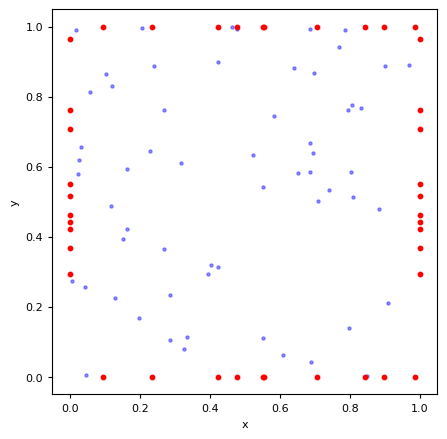

In [ ]:

N_int = int(10*10 - 10*4)
N_bnd = int(10)

# Interior (collocation) points
x_int = torch.rand((N_int, 1), requires_grad=True, device=device)
y_int = torch.rand((N_int, 1), requires_grad=True, device=device)

# Boundary points (x=0,1 and y=0,1)
x_bnd = torch.rand((N_bnd, 1), device=device)
y_bnd = torch.rand((N_bnd, 1), device=device)
bnd_mask = torch.cat([
    torch.cat([torch.zeros_like(y_bnd), y_bnd], dim=1),               # x=0
    torch.cat([torch.ones_like(y_bnd), y_bnd], dim=1),                # x=1
    torch.cat([x_bnd, torch.zeros_like(x_bnd)], dim=1),               # y=0
    torch.cat([x_bnd, torch.ones_like(x_bnd)], dim=1),                # y=1
], dim=0)

x_bnd = bnd_mask[:, 0:1]
y_bnd = bnd_mask[:, 1:2]
f_bnd = torch.zeros_like(x_bnd, device=device)

plt.figure(figsize=(5,5))
plt.scatter(x_int.cpu().detach().numpy(), y_int.cpu().detach().numpy(), s=5, color='blue', alpha=0.4, label='Interior')
plt.scatter(x_bnd.cpu(), y_bnd.cpu(), s=10, color='red', label='Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('square')
plt.show()

def sample_pinn_points(N, device="cpu"):
    """
    Generate random collocation and boundary points matching
    the number of FD grid points for a given N.
    """
    # Number of interior and boundary points
    N_int = (N - 2) ** 2          # FD interior points
    N_bnd = 4 * (N - 1)           # FD boundary points

    # Interior points (exclude boundaries)
    eps = torch.tensor(1e-6, device=device, requires_grad=True)
    x_int = eps + (1 - 2*eps) * torch.rand((N_int, 1), requires_grad=True, device=device)
    y_int = eps + (1 - 2*eps) * torch.rand((N_int, 1), requires_grad=True, device=device)

    # Boundary points
    xb = torch.rand((N_bnd // 4, 1), requires_grad=True, device=device)
    yb = torch.rand((N_bnd // 4, 1), requires_grad=True, device=device)

    bnd_mask = torch.cat([
        torch.cat([torch.zeros_like(yb), yb], dim=1),               # x = 0
        torch.cat([torch.ones_like(yb), yb], dim=1),                # x = 1
        torch.cat([xb, torch.zeros_like(xb)], dim=1),               # y = 0
        torch.cat([xb, torch.ones_like(xb)], dim=1),                # y = 1
    ], dim=0)

    x_bnd = bnd_mask[:, 0:1]
    y_bnd = bnd_mask[:, 1:2]
    f_bnd = torch.zeros_like(x_bnd, device=device)

    return x_int, y_int, x_bnd, y_bnd, f_bnd

In [43]:
def sample_pinn_points(N, device="cpu"):
    """
    Generate random collocation and boundary points matching
    the structure used in the manual setup.
    """
    N_int = N * N - 4 * N
    N_bnd = 4 * N

    # Interior points (exclude boundaries)
    eps = 1e-6
    x_int = eps + (1 - 2*eps) * torch.rand((N_int, 1), device=device)
    y_int = eps + (1 - 2*eps) * torch.rand((N_int, 1), device=device)
    x_int.requires_grad_(True)
    y_int.requires_grad_(True)

    # Boundary points
    xb = torch.rand((N, 1), device=device)
    yb = torch.rand((N, 1), device=device)
    bnd_mask = torch.cat([
        torch.cat([torch.zeros_like(yb), yb], dim=1),  # x=0
        torch.cat([torch.ones_like(yb), yb], dim=1),   # x=1
        torch.cat([xb, torch.zeros_like(xb)], dim=1),  # y=0
        torch.cat([xb, torch.ones_like(xb)], dim=1),   # y=1
    ], dim=0)

    x_bnd = bnd_mask[:, 0:1]
    y_bnd = bnd_mask[:, 1:2]
    f_bnd = torch.zeros_like(x_bnd, device=device)

    return x_int, y_int, x_bnd, y_bnd, f_bnd


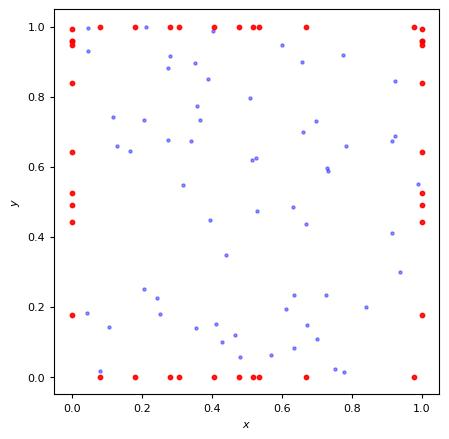

Interior: 60, Boundary: 40, Total: 100


In [54]:
 
 
x_int, y_int, x_bnd, y_bnd, f_bnd = sample_pinn_points(10, device=device)

plt.figure(figsize=(5,5))
plt.scatter(x_int.cpu().detach().numpy(), y_int.cpu().detach().numpy(), s=5, alpha=0.4, label="Interior", color="blue")
plt.scatter(x_bnd.cpu().detach().numpy(), y_bnd.cpu().detach().numpy(), s=10, alpha=0.9, label="Boundary", color="red")
plt.axis("square")
plt.xlabel("$x$")
plt.ylabel("$y$")
#plt.legend()
plt.show()

print(f"Interior: {len(x_int)}, Boundary: {len(x_bnd)}, Total: {len(x_int) + len(x_bnd)}")


## Model and optimizer

In [45]:
layers = [2, 275, 275, 1]
model = PINN(layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## Physics-Informed Loss

In [46]:
# def pinn_loss():
#     # PDE residual
#     f_pred = model(x_int, y_int)
#     grads = torch.autograd.grad(f_pred, [x_int, y_int],
#                                 grad_outputs=torch.ones_like(f_pred),
#                                 create_graph=True)
#     f_x, f_y = grads
#     f_xx = torch.autograd.grad(f_x, x_int, torch.ones_like(f_x), create_graph=True)[0]
#     f_yy = torch.autograd.grad(f_y, y_int, torch.ones_like(f_y), create_graph=True)[0]

#     res = f_xx + f_yy + 2 * (4 * np.pi)**2 * torch.sin(4*np.pi*x_int) * torch.sin(4*np.pi*y_int)
#     loss_pde = torch.mean(res**2)

#     # Boundary
#     f_bnd_pred = model(x_bnd, y_bnd)
#     loss_bnd = torch.mean((f_bnd_pred - f_bnd)**2)

#     return loss_pde + loss_bnd

In [47]:
def pinn_loss():
    # Enforce hard boundary constraint manually in the loss
    f_raw = model(x_int, y_int)  # unconstrained NN output
    f_pred = f_raw  # apply constraint

    # Compute derivatives
    grads = torch.autograd.grad(f_pred, [x_int, y_int],
                                grad_outputs=torch.ones_like(f_pred),
                                create_graph=True)
    f_x, f_y = grads
    f_xx = torch.autograd.grad(f_x, x_int, torch.ones_like(f_x), create_graph=True)[0]
    f_yy = torch.autograd.grad(f_y, y_int, torch.ones_like(f_y), create_graph=True)[0]

    # PDE residual: ∇²f + RHS = 0
    res = f_xx + f_yy + 2 * (4 * np.pi)**2 * torch.sin(4*np.pi*x_int) * torch.sin(4*np.pi*y_int)
    loss_pde = torch.mean(res**2)

    # Boundary loss (optional, small weight to stabilize)
    #f_bnd_raw = model(x_bnd, y_bnd)
    #f_bnd_pred = f_bnd_raw
    #loss_bnd = torch.mean(f_bnd_pred**2)

    return loss_pde  # BC term should be nearly zero anyway

## Training Loop

In [48]:
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4e}")

Epoch 0: Loss = 2.2343e+04
Epoch 500: Loss = 1.6337e+04
Epoch 1000: Loss = 1.1043e+03
Epoch 1500: Loss = 1.8820e+01
Epoch 2000: Loss = 9.8866e+00
Epoch 2500: Loss = 7.1289e+00
Epoch 3000: Loss = 5.0890e+00
Epoch 3500: Loss = 3.3696e+00
Epoch 4000: Loss = 2.1500e+00
Epoch 4500: Loss = 1.5040e+00


In [49]:
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),
                                    max_iter=5000,
                                    tolerance_grad=1e-8,
                                    tolerance_change=1e-9,
                                    history_size=100,
                                    line_search_fn="strong_wolfe")

lbfgs_iter = 0  # to track iterations inside closure

def closure():
    global lbfgs_iter
    optimizer_lbfgs.zero_grad()
    loss = pinn_loss()
    loss.backward()

    # Print progress every 500 iterations
    if lbfgs_iter % 500 == 0:
        print(f"[L-BFGS] Iteration {lbfgs_iter}: Loss = {loss.item():.4e}")
    lbfgs_iter += 1

    return loss

print("\nStarting L-BFGS optimization...")
optimizer_lbfgs.step(closure)
print("L-BFGS optimization complete.")


Starting L-BFGS optimization...
[L-BFGS] Iteration 0: Loss = 1.0911e+00
[L-BFGS] Iteration 500: Loss = 1.6792e-02
L-BFGS optimization complete.


##  Evaluation

In [ ]:
nx, ny = 60, 60
xg = np.linspace(0, 1, nx)
yg = np.linspace(0, 1, ny)
X, Y = np.meshgrid(xg, yg)
XY_torch = torch.tensor(np.column_stack([X.flatten(), Y.flatten()]),
                        dtype=torch.float32, device=device)

with torch.no_grad():
    f_pred = model(XY_torch[:, 0:1], XY_torch[:, 1:2]).cpu().numpy().reshape(ny, nx)

f_true = f_exact(X, Y)

## Plot Results

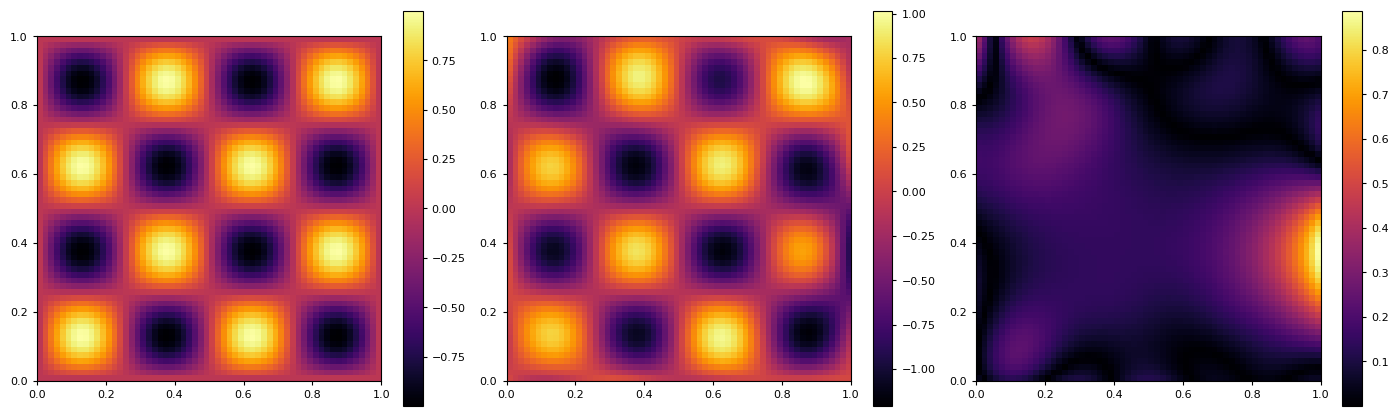

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14,4))
im0 = axs[0].imshow(f_true, extent=[0,1,0,1], origin='lower', cmap='inferno')
 
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(f_pred, extent=[0,1,0,1], origin='lower', cmap='inferno')
 
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(np.abs(f_pred - f_true), extent=[0,1,0,1], origin='lower', cmap='inferno')
 
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

In [ ]:
error_rel = np.linalg.norm(f_pred - f_true, 2) / np.linalg.norm(f_true, 2)
print(f"Relative L2 error: {error_rel:.4e}")

Relative L2 error: 3.4349e-01
